## Бинарная классификация фотографий с кошками и собаками.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from os import listdir
import pandas as pd
import numpy as np
from skimage import io
import random

In [5]:
#Выделим 1000 картинок из трейна для будущего теста модели.

train_data = []
test_data = []

for file in listdir("train/train"):
    some_number = random.randint(1,100)
    label = "1" if "dog" in file else "0" 
    if len(test_data) >= 1000 or some_number < 85:
        train_data.append([file, label])
    else:
        test_data.append([file, label])

# Создадим датафреймы для удобства
train = pd.DataFrame(train_data, columns=["filename", "class"])
test = pd.DataFrame(test_data, columns = ["filename", "class"])

In [52]:
train.head(2)

,filename,class
0,cat.0.jpg,0
1,cat.1.jpg,0


In [53]:
test.head(2)

,filename,class
0,cat.10.jpg,0
1,cat.100.jpg,0


Трансформируем изображения

In [17]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=90, 
                                           horizontal_flip=True, 
                                           vertical_flip=True,
                                           validation_split=0.2)

In [18]:
train_generator = train_image_generator.flow_from_dataframe(train, "train/train", seed=42,
                                                    target_size=(IMG_SIZE[0], IMG_SIZE[1]),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="binary",
                                                    subset="training",
                                                    shuffle=True,      
                                                    save_format="jpeg")

validation_generator = train_image_generator.flow_from_dataframe(train, "train/train", seed=42,
                                                    target_size=(IMG_SIZE[0], IMG_SIZE[1]),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="binary",
                                                    subset="validation",
                                                    shuffle=False,                  
                                                    save_format="jpeg")

Found 19802 images belonging to 2 classes.
Found 4198 images belonging to 2 classes.


## Возьмём предобученную модель VGG16

In [19]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', 
                    include_top=False, 
                    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
                    pooling="avg")

## Обучим 8 последних слоёв.

In [20]:
for layer in model.layers[:-8]:
        layer.trainable = False

## Добавим полносвязный слой

In [21]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential

transfer_model_vgg16 = Sequential()

for layer in model.layers:
    transfer_model_vgg16.add(layer)
transfer_model_vgg16.add(Dense(512, activation="relu"))  
transfer_model_vgg16.add(Dense(1, activation="sigmoid"))

## Посмотрим на полученную архитектуру модели

In [22]:
transfer_model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [24]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
transfer_model_vgg16.compile(adam,loss="binary_crossentropy",metrics=["accuracy"] )

vgg16_model_history = transfer_model_vgg16.fit_generator(train_generator, 
                                             steps_per_epoch = train_generator.n // BATCH_SIZE,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.n // BATCH_SIZE,
                                            epochs=2)

Epoch 1/2
309/309 [==============================] - 3937s 13s/step - loss: 0.3352 - acc: 0.8473 - val_loss: 0.1030 - val_acc: 0.9739
Epoch 2/2
309/309 [==============================] - 3818s 12s/step - loss: 0.1740 - acc: 0.9300 - val_loss: 0.2432 - val_acc: 0.9008


На двух эпохах смогли хорошо дообучить модель и получить Log Loss не более 0.3, согласно заданию.

Посмотрим на результат на тестовой выборке (1000 изображений):

In [54]:
import cv2
from skimage import io

def build_batches(df, has_labels=True, limit=500, batch_size=BATCH_SIZE, produce="images"):
    """
    produce: Can be either "images" in which case an array of normalized images is returned or 
             "paths" in which case, a string with the full dir is returned
    """
    X = []
    y = []
    paths = []
    i = 0
    for _, row in df.iterrows():
        if has_labels:
            y.append(row["class"])
        raw_image_path = "train/train/" if has_labels else "test/test/"
        raw_image_path += row["filename"]
        raw_image = io.imread(raw_image_path)
        raw_image = cv2.resize(raw_image, (IMG_SIZE[0], IMG_SIZE[1]), interpolation=cv2.INTER_CUBIC)
        X.append(raw_image)
        paths.append(raw_image_path)
        i += 1
        if i == limit:
            break
        if i > 0 and i % batch_size == 0:
            X = np.array(X)
            y = np.array(y)
            X = X / 255
            
            if produce == "images":
                yield X, y
            else:
                yield paths, y
            paths = []
            X = []
            y = []

    X = np.array(X)
    y = np.array(y)
    
    X = X / 255
    
    if produce == "images":
        yield X, y         
    else:
        yield paths, y

In [55]:
samples = 1000
transfer_model_vgg16.evaluate_generator(build_batches(test, limit=samples), steps=samples/BATCH_SIZE, verbose=True)

16/15 [==============================] - 110s 7s/step


[0.25907485604286196, 0.9009999990463257]

In [43]:
my_limit = 12500
i = 0
output_df = []
for file in listdir("test/test/"):    
    output_df.append([file, file.split(".")[0]])
    i += 1
    if i == my_limit:
        break
output = pd.DataFrame(output_df, columns=["filename", "id"])
print(len(output))
output.head()

12500


,filename,id
0,1.jpg,1
1,10.jpg,10
2,100.jpg,100
3,1000.jpg,1000
4,10000.jpg,10000


In [44]:
results = transfer_model_vgg16.predict_generator(build_batches(output, limit=-1, has_labels=False, batch_size=64), steps=12500/64, verbose=True)

196/195 [==============================] - 1385s 7s/step


In [45]:
results.shape

(12500, 1)

In [46]:
output["label"] = results
output.head()

,filename,id,label
0,1.jpg,1,0.992800
1,10.jpg,10,0.000075
2,100.jpg,100,0.912319
3,1000.jpg,1000,0.999970
4,10000.jpg,10000,0.991246


## Выведем изображения с предсказаниями, которые у нас получились.

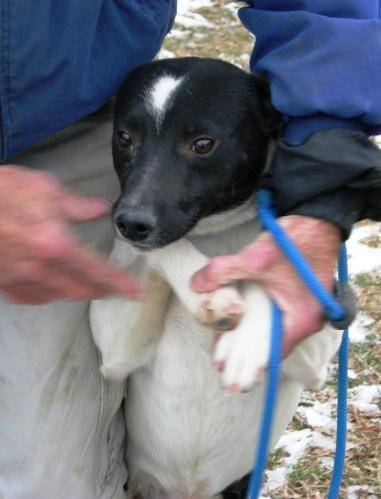

The image test/test/1.jpg above is a dog with a confidence of 99.28% 0.992800


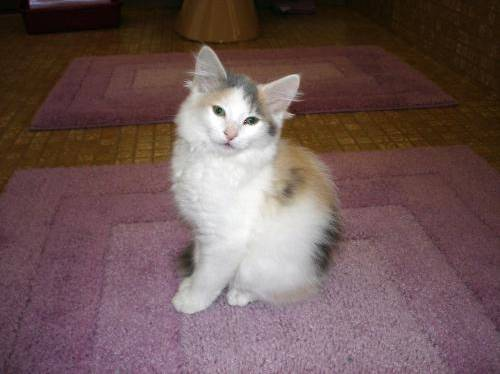

The image test/test/10.jpg above is a cat with a confidence of 99.99% 0.000075


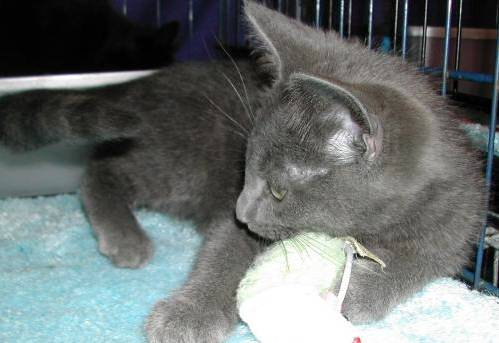

The image test/test/100.jpg above is a dog with a confidence of 91.23% 0.912319


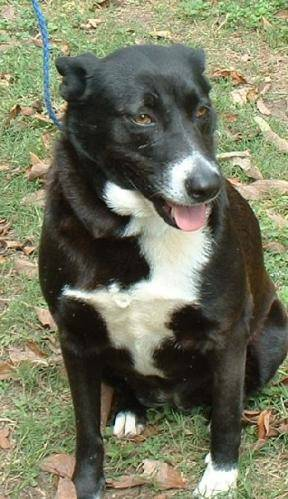

The image test/test/1000.jpg above is a dog with a confidence of 100.00% 0.999970


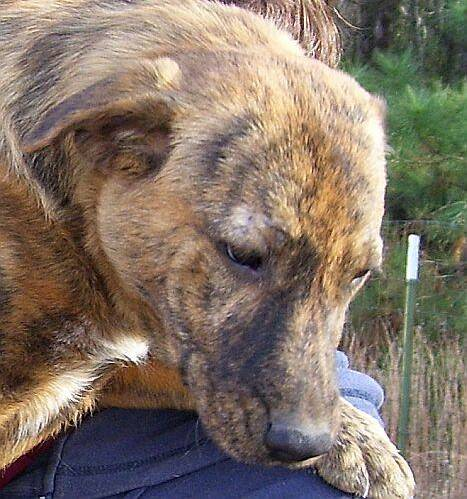

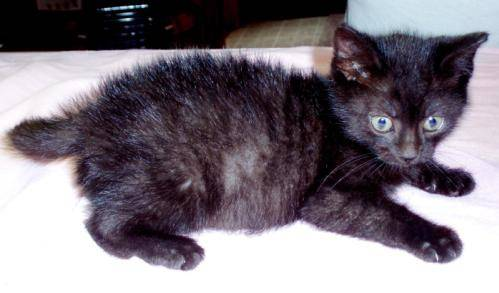

The image test/test/10000.jpg above is a dog with a confidence of 99.12% 0.991246
The image test/test/10001.jpg above is a cat with a confidence of 99.98% 0.000204


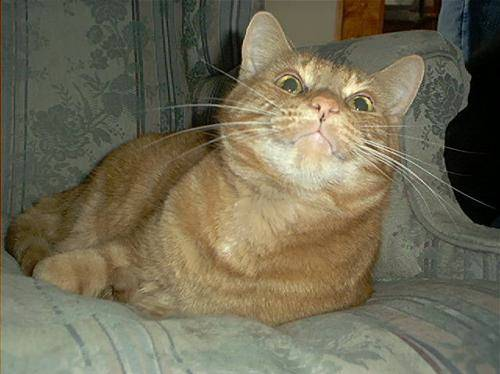

The image test/test/10002.jpg above is a cat with a confidence of 100.00% 0.000036


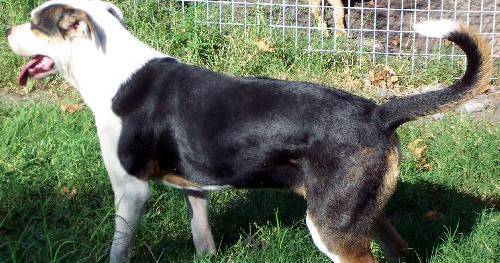

The image test/test/10003.jpg above is a dog with a confidence of 100.00% 0.999961


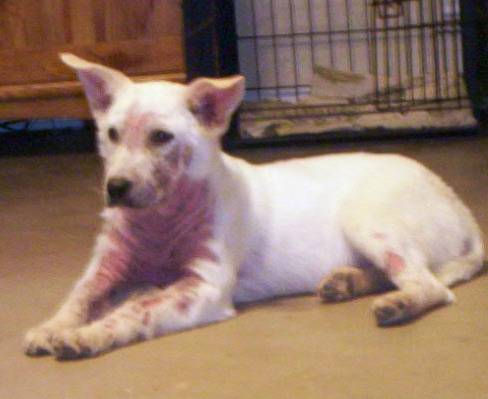

The image test/test/10004.jpg above is a dog with a confidence of 51.17% 0.511694


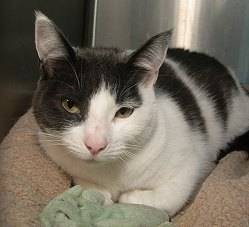

The image test/test/10005.jpg above is a cat with a confidence of 100.00% 0.000036


In [47]:
stop = 10
for idx, row in output.iterrows():
    path = "test/test/" + row["id"] + ".jpg"
    plot_prediction(path, row["label"])
    stop -= 1
    if stop == 0:
        break

## Приготовим сабмит для проверки качества модели на Каггле

In [48]:
del output["filename"]

In [49]:
output.head()

,id,label
0,1,0.992800
1,10,0.000075
2,100,0.912319
3,1000,0.999970
4,10000,0.991246


In [51]:
output.to_csv("submission_file.csv", index=False)

На лидерборде получили скор: 0.16824

## Предобученные модели действительно помогают создать работающие модели на новой задаче. Перебор архитектур и эксперименты со слоями помогут добиться более точного результата.